In [2]:
from src import coil_helpers

import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from src import coil_class as BC

import magpylib as magpy
import matplotlib.ticker as ticker

import scipy.constants as const
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [3]:
def circular_HH(HH, radius, distance, layers, windings,
                I = 1, #A
                wire_height = .5 *1e-3,
                wire_width = .5 *1e-3,
                insulation_thickness = (0.552-0.5)/2 *1e-3,
                print_info = True):
    """returns magpylib system for a circular HH-coil (parameters in m) and prints info on it if requested"""

    #### give out coil parameter s####
    HH_Coil = BC.BCoil(HH = HH, distance = distance*1e3, radius = radius*1e3, layers = layers, windings = windings,
                    wire_height = wire_height*1e3, wire_width = wire_width*1e3, insulation_thickness = insulation_thickness*1e3,
                    is_round = True, winding_scheme= 2)

    if print_info:
        print("Single coil parameters:")

        HH_Coil.print_info()
        print(f"N = {HH_Coil.get_N()}")
        print(f"wire length = {HH_Coil.get_wire_length()} m")

        HH_Coil.plot_raster()

        #### total inductance from Lenny's code ####
        def Self_Inductance_Abbot(alpha, beta, gamma, N):
            """
            Formula for self inductance of circular coil by J.J.Abbott
            """
            L = (7.9e-6 * alpha**2 * N**2) / (3*alpha + 9*beta + 10*gamma)
            return L

        alpha = 2*radius
        beta = HH_Coil.get_coil_width()
        gamma = HH_Coil.get_coil_height()
        N = HH_Coil.get_N()
        dist = distance

        L_pair = Self_Inductance_Abbot(alpha, dist + beta, gamma, N) +Self_Inductance_Abbot(alpha, dist - beta, gamma, N) - 2 * Self_Inductance_Abbot(alpha, dist, gamma, N) + 2 * Self_Inductance_Abbot(alpha, beta, gamma, N)
        R_pair = 2*HH_Coil.get_wire_length() * 0.08708

        print("Pair in series:")
        print(f"wire length = {2*HH_Coil.get_wire_length()} m")
        print(f"R = {2*HH_Coil.resistance(25)} Ohm")
        print(f"L = {L_pair*1e3} mH")
        print(f"tau = {L_pair/R_pair*1e3} ms")

        print(f"\nat {I} A:")
        print(f"V = {R_pair*I} V")
        print(f"P = {R_pair*I**2} W")

    #### calculate field properties ####

    #define coils
    winding_offsets = HH_Coil.full_raster(raster_value=1)[:,0]

    coil1 = magpy.Collection()
    for coord in winding_offsets:
        winding = magpy.current.Circle(
            current=I,
            diameter=2*coord[1],
            position=(0,0,coord[0]),
        )
        coil1.add(winding)

    coil2 = magpy.Collection()
    for coord in winding_offsets:
        winding = magpy.current.Circle(
            current=HH*I,
            diameter=2*coord[1],
            position=(0,0,-coord[0]),
        )
        coil2.add(winding)

    #move to test if slight changes in positioning have a large effect
    #coil1.move([0.5e-3,0,0])

    # Combine them into a collection (like multiple windings)
    #system = magpy.Collection(coil1, coil2)
    system = coil1

    return system, 2*HH_Coil.get_wire_length()

Single coil parameters:
 
HH = 1, Distance = 65.0 mm, z_min = 29.740 mm, z_max = 35.260 mm
Radius = 65.000 mm, Radius_inner = 63.051 mm, Radius_outer = 66.949 mm
Coil width = 3.898 mm, Coil height = 5.520 mm
layers = 8, windings = 10, wire_width = 0.500, wire_height = 0.500 mm, round wire = True 
 
N = 76
wire length = 31.038935417467158 m


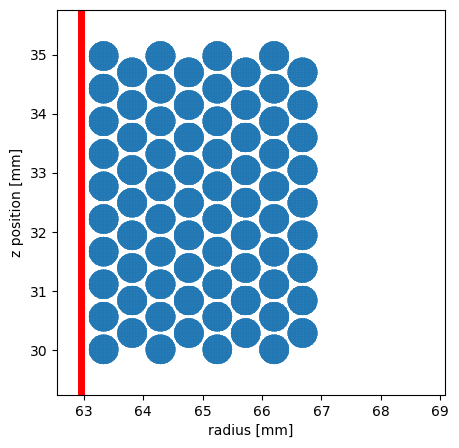

Pair in series:
wire length = 62.077870834934316 m
R = 5.544807756800001 Ohm
L = 3.2129730732336395 mH
tau = 0.5943631183600215 ms

at 1 A:
V = 5.405740992306081 V
P = 5.405740992306081 W


Magnetic field at center: [0.         0.         5.25683494] G/A
max. heterogeneity at 1mm: 1.844e-02


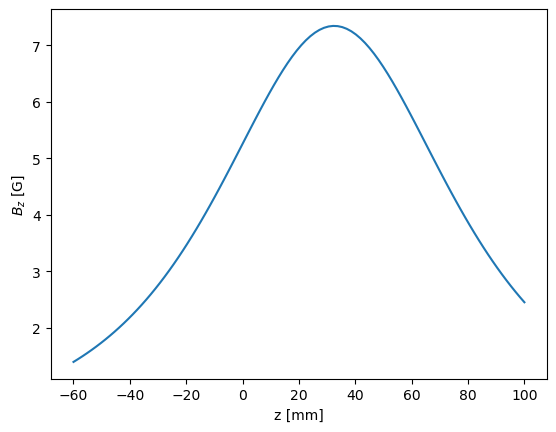

In [4]:
system, len_z = circular_HH(HH=1,
                                    radius=65*1e-3,
                                    distance=65*1e-3,
                                    layers=8,
                                    windings=10,
                                    I=1)
system.show()

# Evaluate field at a point
origin = 0
B0 = system.getB([origin, origin, origin])
print("Magnetic field at center:", B0*1e4, "G/A")

#cacluclate heterogeneity (for circular along symmetry axis)
offset = 1e-3 #m
eval_pos = [origin,origin,origin+offset]
err = np.linalg.norm(B0 - system.getB(eval_pos))/np.linalg.norm(B0)
print(f"max. heterogeneity at 1mm: {err:.3e}")


N_plot = 100

# Evaluate field though centre line
positions = np.zeros((N_plot,3))
#positions[:,0] = np.ones(N_plot)*5e-3
positions[:,2] = np.linspace(-60*1e-3,100*1e-3,N_plot)
B_l = system.getB(positions)


plt.plot(positions[:,2]*1e3,B_l[:,2]*1e4)
plt.xlabel("z [mm]")
plt.ylabel(r"$B_z$ [G]")
plt.show()

#fit function for later
def fit_low(z, offset):
    interp_l = interp1d(positions[:,2], B_l[:,2])
    try:
        return interp_l(z+offset)
    except:
        return np.nan

Single coil parameters:
 
HH = 1, Distance = 50.0 mm, z_min = 21.964 mm, z_max = 28.036 mm
Radius = 50.000 mm, Radius_inner = 43.987 mm, Radius_outer = 56.013 mm
Coil width = 12.025 mm, Coil height = 6.072 mm
layers = 25, windings = 11, wire_width = 0.500, wire_height = 0.500 mm, round wire = True 
 
N = 263
wire length = 82.62388678941156 m


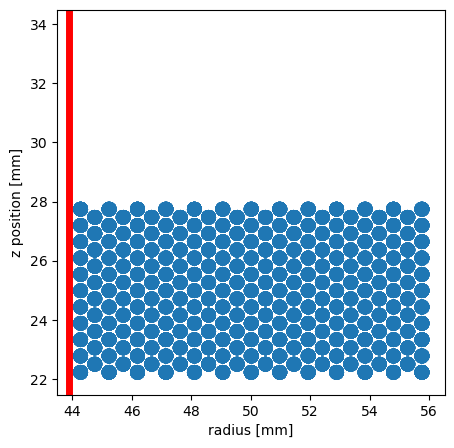

Pair in series:
wire length = 165.24777357882311 m
R = 14.759963968 Ohm
L = 23.549406552755187 mH
tau = 1.636537382587603 ms

at 1 A:
V = 14.389776123243918 V
P = 14.389776123243918 W


Magnetic field at center: [ 0.         0.        23.6256662] G/A
max. heterogeneity at 1mm: 2.419e-02


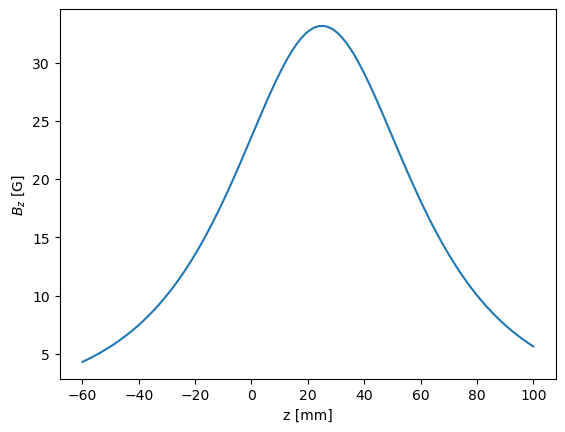

In [5]:
system, len_z = circular_HH(HH=1,
                                    radius=50*1e-3,
                                    distance=50*1e-3,
                                    layers=25,
                                    windings=11,
                                    I=1)
system.show()

# Evaluate field at a point
origin = 0
B0 = system.getB([origin, origin, origin])
print("Magnetic field at center:", B0*1e4, "G/A")

#cacluclate heterogeneity (for circular along symmetry axis)
offset = 1e-3 #m
eval_pos = [origin,origin,origin+offset]
err = np.linalg.norm(B0 - system.getB(eval_pos))/np.linalg.norm(B0)
print(f"max. heterogeneity at 1mm: {err:.3e}")


N_plot = 100

# Evaluate field though centre line
positions = np.zeros((N_plot,3))
positions[:,2] = np.linspace(-60*1e-3,100*1e-3,N_plot)
B = system.getB(positions)


plt.plot(positions[:,2]*1e3,B[:,2]*1e4)
plt.xlabel("z [mm]")
plt.ylabel(r"$B_z$ [G]")
plt.show()

#fit function for later
def fit_high(z, offset):
    interp = interp1d(positions[:,2], B[:,2])
    try:
        return interp(z+offset)
    except:
        return np.nan

## Single current loop calculation for high-field coil:

In [6]:
I = 1 #A
R = 65*1e-3 #m
N = 76

B_single = const.mu_0* I/2/R

B_coil = N* B_single

B_coil*1e4

7.346493593932307

In [7]:
I = 1 #A
R = 50*1e-3 #m
N = 263

B_single = const.mu_0* I/2/R

B_coil = N* B_single

B_coil*1e4

33.049554733756

# Calibrate measurements

In [8]:
def cal_B(B_meas):
    """
    Returns correct field using the calibration in OneNote
    (in and out in Gauss)
    """
    return (B_meas - 6.072)*0.496

In [9]:
def cal_B(B_meas):
    """
    Returns correct field using the calibration in Joschkas thesis
    (in and out in Gauss)
    """
    #return (B_meas - 11.2)*7.93/16.08
    return (B_meas - 10)*0.49

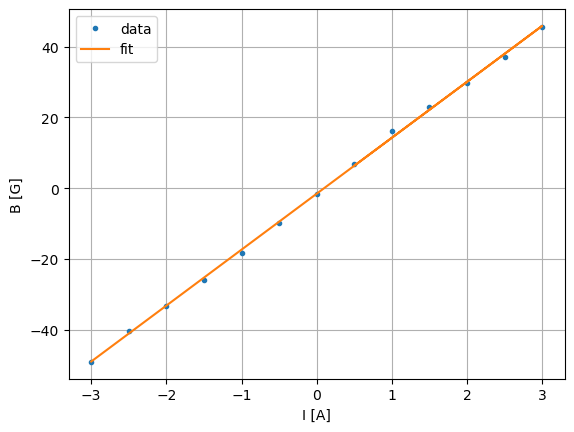

-1.5394615384670778
0.46508439798981116


In [10]:
data = np.genfromtxt('data/cal_N76', delimiter=';', dtype=None, encoding='utf-8')

B_z = data[:,0]

B_z_0 = B_z[0::10]
B_z_1 = B_z[1::10]
B_z_2 = B_z[2::10]
B_z_3 = B_z[3::10]
B_z_4 = B_z[4::10]
B_z_5 = B_z[5::10]
B_z_6 = B_z[6::10]
B_z_7 = B_z[7::10]
B_z_8 = B_z[8::10]
B_z_9 = B_z[9::10]

B_z_mean = (B_z_0 + B_z_1 + B_z_2 + B_z_3 + B_z_4 + 
            B_z_5 + B_z_6 + B_z_7 + B_z_8 + B_z_9)/10
I_meas = np.array([0.5,1,1.5,2,2.5,3,0,-0.5,-1,-1.5,-2,-2.5,-3])

def lin_fit(x,m,b):
    return m*x+b

popt, pcov = curve_fit(lin_fit,I_meas, B_z_mean)

plt.plot(I_meas,B_z_mean,".",label="data")
plt.plot(I_meas, lin_fit(I_meas,*popt),label="fit")
plt.xlabel("I [A]")
plt.ylabel("B [G]")
plt.grid()
plt.legend()
plt.show()

N = 76
R = 65*1e-3 #m
m = popt[0]
b = popt[1]

c = const.mu_0*N/2/R *1e4 #converted to Gauss

print(b)
print(c/m)

def cal_B(B_meas):
    """
    Returns correct field using own calibration
    (in and out in Gauss)
    """
    return (B_meas - b)*c/m

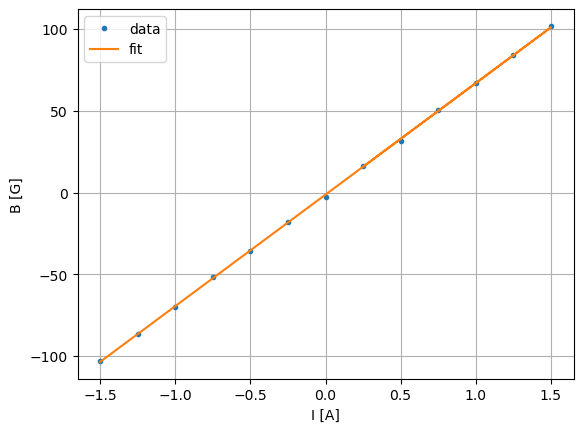

-1.2406153846202757
0.48447267643373365


In [11]:
data = np.genfromtxt('data/cal_N263', delimiter=';', dtype=None, encoding='utf-8')

B_z = data[:,0]

B_z_0 = B_z[0::5]
B_z_1 = B_z[1::5]
B_z_2 = B_z[2::5]
B_z_3 = B_z[3::5]
B_z_4 = B_z[4::5]

B_z_mean = (B_z_0 + B_z_1 + B_z_2 + B_z_3 + B_z_4)/5
I_meas = np.array([0.25,0.5,0.75,1,1.25,1.5,0,-0.25,-0.5,-0.75,-1,-1.25,-1.5])

def lin_fit(x,m,b):
    return m*x+b

popt, pcov = curve_fit(lin_fit,I_meas, B_z_mean)

plt.plot(I_meas,B_z_mean,".",label="data")
plt.plot(I_meas, lin_fit(I_meas,*popt),label="fit")
plt.xlabel("I [A]")
plt.ylabel("B [G]")
plt.grid()
plt.legend()
plt.show()

N = 263
R = 50*1e-3 #m
m = popt[0]
b = popt[1]

c = const.mu_0*N/2/R *1e4 #converted to Gauss

print(b)
print(c/m)

def cal_B(B_meas):
    """
    Returns correct field using own calibration
    (in and out in Gauss)
    """
    return (B_meas - b)*c/m

# Load data from measurements

In [12]:
start = 18-19.87 #mm

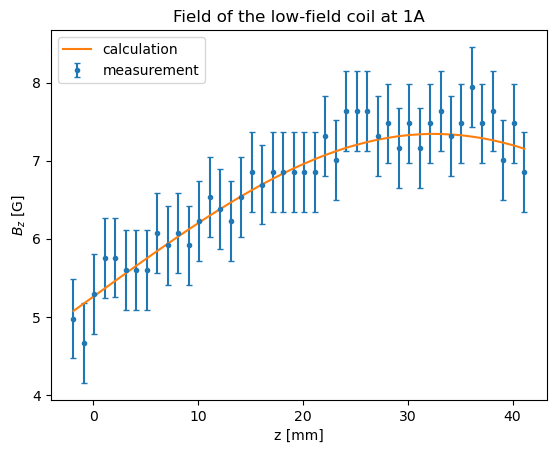

In [13]:
data = np.genfromtxt('data/final_76_1A', delimiter=';', dtype=None, encoding='utf-8')

#I = 2 #A

B_z = cal_B(data[:,0])*1e-4

B_z_0 = B_z[0::10]
B_z_1 = B_z[1::10]
B_z_2 = B_z[2::10]
B_z_3 = B_z[3::10] 
B_z_4 = B_z[4::10]
B_z_5 = B_z[5::10]
B_z_6 = B_z[6::10]
B_z_7 = B_z[7::10]
B_z_8 = B_z[8::10]
B_z_9 = B_z[9::10]

B_z_mean = (B_z_0 + B_z_1 + B_z_2 + B_z_3 + B_z_4 + 
            B_z_5 + B_z_6 + B_z_7 + B_z_8 + B_z_9)/10
        
positions_meas = np.arange(start,start+1*len(B_z_mean),1)*1e-3

plt.errorbar(positions_meas*1e3,B_z_mean*1e4,np.ones(len(B_z_mean))*3.23/2/np.sqrt(10),
                fmt=".",capsize=2,label="measurement")
plt.plot(positions_meas*1e3,fit_low(positions_meas, 0)*1e4,label="calculation")

#plt.xlim(0,np.max(positions_meas)*1e3)
plt.xlabel("z [mm]")
plt.ylabel(r"$B_z$ [G]")

plt.title("Field of the low-field coil at 1A")
plt.legend()
plt.show()

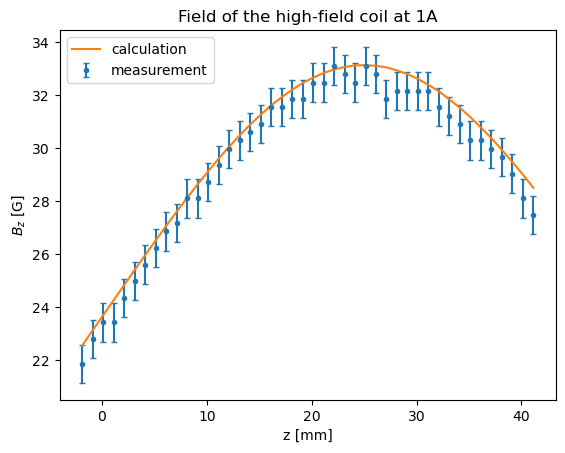

In [14]:
data = np.genfromtxt('data/final_263_1A', delimiter=';', dtype=None, encoding='utf-8')

#I = 1 #A

B_z = cal_B(data[:,0])*1e-4

B_z_0 = B_z[0::5]
B_z_1 = B_z[1::5]
B_z_2 = B_z[2::5]
B_z_3 = B_z[3::5]
B_z_4 = B_z[4::5]

B_z_mean = (B_z_0 + B_z_1 + B_z_2 + B_z_3 + B_z_4)/5
positions_meas = np.arange(start,start+1*len(B_z_mean),1)*1e-3

plt.errorbar(positions_meas*1e3,B_z_mean*1e4,np.ones(len(B_z_mean))*3.23/2/np.sqrt(5),
                fmt=".",capsize=2,label="measurement")
plt.xlabel("z [mm]")
plt.ylabel(r"$B_z$ [G]")
    
plt.plot(positions_meas*1e3,fit_high(positions_meas, 0)*1e4,label="calculation")
plt.xlabel("z [mm]")
plt.ylabel(r"$B_z$ [G]")

plt.title("Field of the high-field coil at 1A")
plt.legend()
plt.show()